###Import and install

In [ ]:
!pip install kaggle
!pip install plotly

import networkx as nx
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

###Source the data

In [ ]:
!mkdir -p ./data

# Download the datasets
!kaggle datasets download -d atharvasoundankar/global-music-streaming-trends-and-listener-insights -p ./data
!kaggle datasets download -d smayanj/netflix-users-database -p ./data
!kaggle datasets download -d imtkaggleteam/mental-health -p ./data

# Unzip the files into the data directory
!unzip ./data/global-music-streaming-trends-and-listener-insights.zip -d ./data
!unzip ./data/netflix-users-database.zip -d ./data
!unzip ./data/mental-health.zip -d ./data

music_df = pd.read_csv('./data/Global_Music_Streaming_Listener_Preferences.csv')
netflix_df = pd.read_csv('./data/netflix_users.csv')
mental_health_df = pd.read_csv('./data/1- mental-illnesses-prevalence.csv')

###Preporcess the data COVID onwards

In [ ]:
# Filter for 2016 onwards
mental_health_df = mental_health_df[mental_health_df['Year'] >= 2016]

# Select only the disorder columns
disorder_columns = [col for col in mental_health_df.columns if 'disorders' in col.lower()]

# Filter out non-country entities (those with NaN in 'Code' or containing '(IHME GBD)')
mental_health_df = mental_health_df[mental_health_df['Code'].notna()]  # Keep only rows with valid country codes
mental_health_df = mental_health_df[~mental_health_df['Entity'].str.contains('IHME GBD')]  # Exclude regions

# Average prevalence rates by country, only for disorder columns
mental_health_avg = mental_health_df.groupby('Entity')[disorder_columns].mean().reset_index()

# Set country as index for merging
mental_health_avg = mental_health_avg.set_index('Entity')


In [ ]:
# Music aggregation
music_genre_percent = music_df.groupby('Country')['Top Genre'].value_counts(normalize=True).unstack(fill_value=0) * 100
music_genre_percent = music_genre_percent.add_prefix('Music_')
music_avg_min = music_df.groupby('Country')['Minutes Streamed Per Day'].mean().rename('Avg_Music_Min_Per_Day')
music_aggregate = pd.concat([music_genre_percent, music_avg_min], axis=1)

# Netflix aggregation
netflix_genre_percent = netflix_df.groupby('Country')['Favorite_Genre'].value_counts(normalize=True).unstack(fill_value=0) * 100
netflix_genre_percent = netflix_genre_percent.add_prefix('Netflix_')
netflix_avg_hours = netflix_df.groupby('Country')['Watch_Time_Hours'].mean().rename('Avg_Netflix_Hours')
netflix_aggregate = pd.concat([netflix_genre_percent, netflix_avg_hours], axis=1)

###Merge the dataset

In [ ]:
# Merge music and Netflix data
user_data_aggregate = music_aggregate.merge(netflix_aggregate, left_index=True, right_index=True, how='inner')

# Merge with mental health data
merged_df = user_data_aggregate.merge(mental_health_avg[disorder_columns], left_index=True, right_index=True, how='inner')

###Compute the data

In [ ]:
# Define media columns
genre_and_avg_columns = (list(music_genre_percent.columns) + ['Avg_Music_Min_Per_Day'] +
                         list(netflix_genre_percent.columns) + ['Avg_Netflix_Hours'])

# Compute correlation matrix
correlation_matrix = merged_df[genre_and_avg_columns + disorder_columns].corr()

# Extract relevant correlations
corr_media_vs_disorders = correlation_matrix.loc[genre_and_avg_columns, disorder_columns]

###Visualize

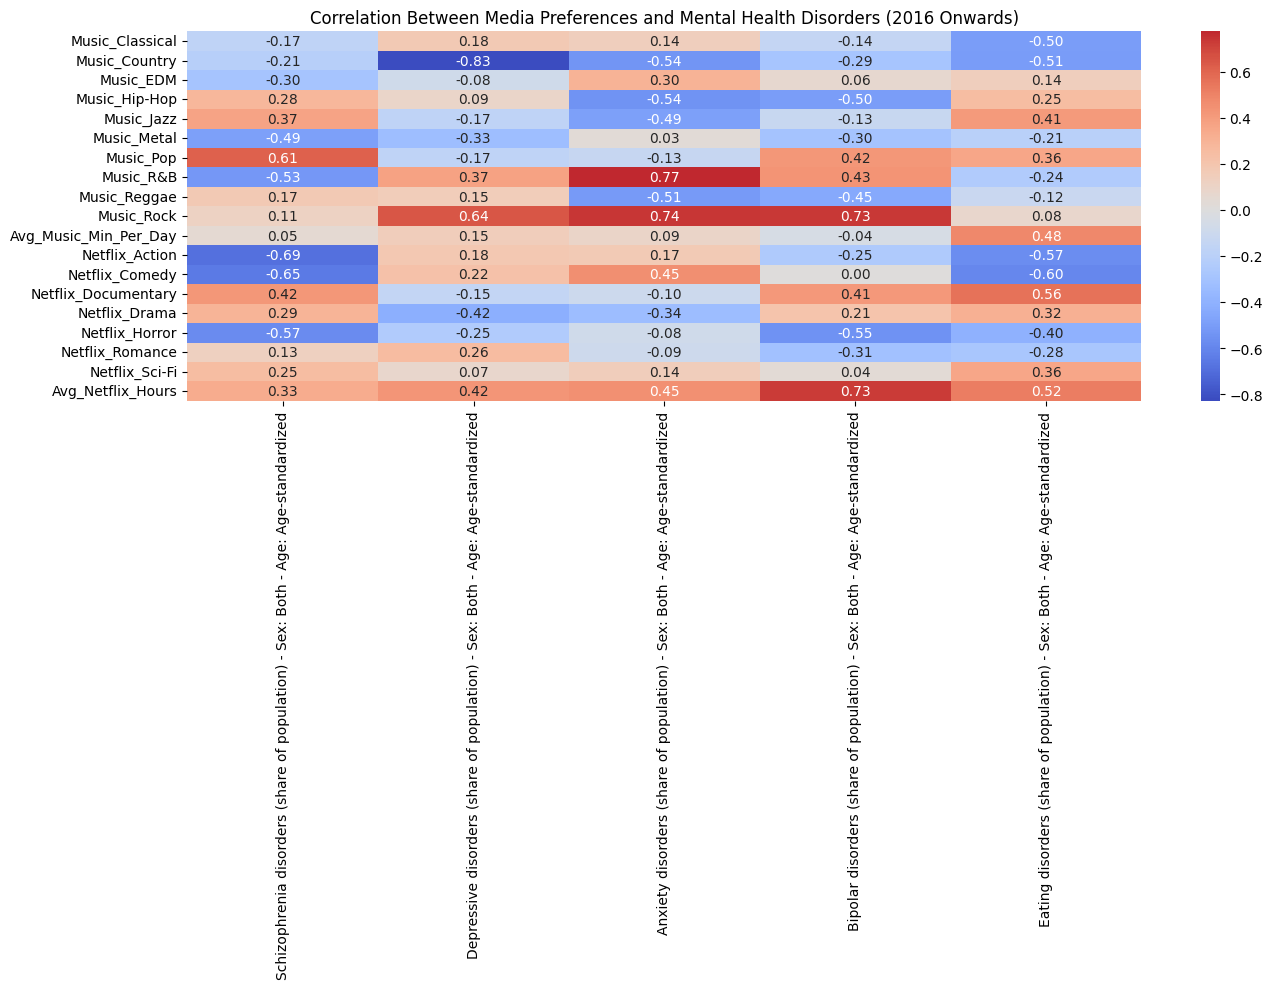

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(corr_media_vs_disorders, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Between Media Preferences and Mental Health Disorders (2016 Onwards)')
plt.tight_layout()
plt.show()

In [ ]:
# Initialize the graph
G = nx.Graph()

# Shorten disorder names
disorder_short_names = {
    'Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized': 'Schizophrenia',
    'Depressive disorders (share of population) - Sex: Both - Age: Age-standardized': 'Depression',
    'Anxiety disorders (share of population) - Sex: Both - Age: Age-standardized': 'Anxiety',
    'Bipolar disorders (share of population) - Sex: Both - Age: Age-standardized': 'Bipolar',
    'Eating disorders (share of population) - Sex: Both - Age: Age-standardized': 'Eating'
}
disorders = [disorder_short_names[col] for col in disorder_columns]
for disorder in disorders:
    G.add_node(disorder, category='disorder')

# Add countries (top 5 by depression prevalence)
top_countries = merged_df['Depressive disorders (share of population) - Sex: Both - Age: Age-standardized'].nlargest(5).index.tolist()
for country in top_countries:
    G.add_node(country, category='country')
    for full_disorder, short_disorder in disorder_short_names.items():
        prevalence = merged_df.loc[country, full_disorder]
        if prevalence > 4:
            G.add_edge(country, short_disorder, weight=prevalence, label=f'{prevalence:.1f}%')

# Add music genres (significant correlations)
music_genres = [col for col in merged_df.columns if col.startswith('Music_')]
for genre in music_genres:
    short_genre = genre.replace('Music_', '')
    G.add_node(short_genre, category='music_genre')
    for full_disorder, short_disorder in disorder_short_names.items():
        corr = corr_media_vs_disorders.loc[genre, full_disorder]
        if abs(corr) > 0.5:
            G.add_edge(short_genre, short_disorder, weight=corr, label=f'{corr:.2f}')

# Add movie genres (significant correlations)
movie_genres = [col for col in merged_df.columns if col.startswith('Netflix_')]
for genre in movie_genres:
    short_genre = genre.replace('Netflix_', '')
    G.add_node(short_genre, category='movie_genre')
    for full_disorder, short_disorder in disorder_short_names.items():
        corr = corr_media_vs_disorders.loc[genre, full_disorder]
        if abs(corr) > 0.5:
            G.add_edge(short_genre, short_disorder, weight=corr, label=f'{corr:.2f}')

# Add screen time
G.add_node('Screen Time', category='screen_time')
for full_disorder, short_disorder in disorder_short_names.items():
    corr = corr_media_vs_disorders.loc['Avg_Netflix_Hours', full_disorder]
    if abs(corr) > 0.5:
        G.add_edge('Screen Time', short_disorder, weight=corr, label=f'{corr:.2f}')

# Add listening time
G.add_node('Listening Time', category='listening_time')
for full_disorder, short_disorder in disorder_short_names.items():
    corr = corr_media_vs_disorders.loc['Avg_Music_Min_Per_Day', full_disorder]
    if abs(corr) > 0.5:
        G.add_edge('Listening Time', short_disorder, weight=corr, label=f'{corr:.2f}')

# Generate positions using networkx
pos = nx.spring_layout(G, k=0.6, iterations=50)

# Extract node and edge data for Plotly
node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]
node_text = [f"{node}<br>{G.nodes[node].get('label', '')}" for node in G.nodes()]

# Color coding with softer tones
color_map = {
    'disorder': '#FF9999',      # Soft Red
    'country': '#99CCFF',       # Soft Blue
    'music_genre': '#99FF99',   # Soft Green
    'movie_genre': '#CC99FF',   # Soft Purple
    'screen_time': '#FFCC99',   # Soft Orange
    'listening_time': '#FFFF99' # Soft Yellow
}
node_colors = [color_map[G.nodes[node]['category']] for node in G.nodes()]

# Edge traces
edge_x = []
edge_y = []
edge_text = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_text.append(edge[2]['label'])

# Create the Plotly figure
fig = go.Figure()

# Add edges
fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1.5, color='#888888'),  # Soft gray for edges
    hoverinfo='none',
    mode='lines'
))

# Add nodes
fig.add_trace(go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    marker=dict(size=20, color=node_colors, line=dict(width=1, color='#FFFFFF')),
    text=[node for node in G.nodes()],
    textposition='middle center',
    hoverinfo='text',
    hovertext=node_text
))

# Add edge labels
for i, (x0, x1, _) in enumerate(zip(edge_x[::3], edge_x[1::3], edge_x[2::3])):
    y0, y1 = edge_y[i*3], edge_y[i*3+1]
    fig.add_annotation(
        x=(x0 + x1) / 2, y=(y0 + y1) / 2,
        text=edge_text[i],
        showarrow=False,
        font=dict(size=10),
        bgcolor='rgba(255, 255, 255, 0.8)'
    )

# Update layout
fig.update_layout(
    title='Mental Health Disorders and Related Factors',
    title_font_size=16,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20, l=5, r=5, t=40),
    width=800, height=600,
    paper_bgcolor='white',
    plot_bgcolor='white'
)

# Show the interactive plot
fig.show()

###Insights

In [ ]:
# Generate insights
insights = []
threshold = 0.5  # Adjust this threshold as needed

for genre in genre_and_avg_columns:
    for disorder in disorder_columns:
        corr = corr_media_vs_disorders.loc[genre, disorder]
        if abs(corr) > threshold:
            if genre.startswith('Music_'):
                desc = f"the percentage of users who prefer {genre.replace('Music_', '')} music"
            elif genre.startswith('Netflix_'):
                desc = f"the percentage of users who prefer {genre.replace('Netflix_', '')} on Netflix"
            else:
                desc = f"the {genre.replace('_', ' ').lower()}"
            insight = (f"There is a {'positive' if corr > 0 else 'negative'} correlation of {corr:.2f} "
                       f"between {desc} and the average prevalence of {disorder.lower()} from 2016 onwards across countries.")
            insights.append(insight)

# Save insights
with open('mental_health_media_insights_2016_onwards.txt', 'w') as f:
    for insight in insights:
        f.write(insight + '\n')

print(f"Generated {len(insights)} insights. Check 'mental_health_media_insights_2016_onwards.txt'.")

Generated 21 insights. Check 'mental_health_media_insights_2016_onwards.txt'.
